In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def getCloseData(ticker, start, end=None):
    """
    종가 데이터
    ticker: 종목 번호
    start: 시작일
    end: 마지막 날짜
    return: 종목의 종가 데이터
    """
    return fdr.DataReader(ticker, start, end)['Close']

def getDayReturn(closeDataSet):
    """
    개별종목 일별 수익률
    closeDataSet: 종가 데이터
    return: 종가 데이터의 일별 수익률
    """
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet):
    """
    개별종목 누적수익률 == 자산흐름
    closeDataSet: 종가 데이터
    return:종가데이터 누적수익률
    """
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight=None):
    """
    포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    # 개별종목 일별 수익률
    dayReturn = getDayReturn(closeDataSet)
    # 개별종목 누적 수익률
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    # 자산별 비중. 기본값: 동일비중
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    # 포트폴리오 누적 수익률
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    # 포트폴리오 일별 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    """
    cagr, dd, mdd
    투자 성과 지표
    """
    # cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    # mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()
    
    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd

def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
        
    if period == "quarter":
        # 3 6 9 12월 말에 리밸런싱
        # np where 같은걸로 3, 6, 9, 12월 데이터만 가져오고
        # drop_duplicates keep last 하면 됌
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        
    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                              index=rebalancingDate,
                              columns=closeDataSet.columns)
    # 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
      
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getWeightByAvgMomentumScore(closeDataSet, n = 12):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """
    avgMomentumScore = 0 # 평모스 초기값
    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터
    
    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(i) > 1, 1, 0) + avgMomentumScore
        
    # 평모스 계산
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=priceOnRebalDate.index, columns=priceOnRebalDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / n
    
    # 모멘텀 스코어에 따른 weight 계산
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0)
    # 투자 비중이 모두 0인 구간에서는 현금 보유
    weight['cash'] = np.where(weight.sum(axis=1) == 0, 1, 0)
    
    # 투자비중, 평모스 리턴
    return weight, avgMomentumScore

**공통 초기설정: 데이터 로드, 리밸런싱 날짜**  

In [2]:
closeDataSet = pd.read_csv("./동적자산배분데이터.csv", index_col=0, parse_dates=True)
rebalDate = getRebalancingDate(closeDataSet)

# 현금 가격 데이터 추가
closeDataSet['cash'] = 1

**GTAA 전략**

In [3]:
def getGTAAWeight(closeDataSet):
    # gtaa 전략 종목 유니버스
    gtaaCol = ['SPY', 'EFA', "IEF", "DBC", "VNQ"]
    
    gtaaData = closeDataSet[gtaaCol]
    
    # 모멘텀 스코어 계산
    # 5개 자산에 각 20% 비중으로 투자하되, 모멘텀 스코어 0 미만인 자산의 비중만큼은 현금 보유
    # 모멘텀 스코어 = (가격 / 10개월 이동평균) - 1
    ma200 = gtaaData.rolling(window=200).mean() # 10개월 이동평균, 200일선
    momentumScore = (gtaaData / ma200) -1 # 모멘텀 스코어 계산
    momentumScore.dropna(inplace=True) # 결측치 버리기
    
    # 리밸런싱 일자
    gtaaRebalDate = getRebalancingDate(momentumScore) 
    
    # weightDf 계산하기
    # 5개 자산에 각 20% 비중으로 투자하되, 모멘텀 스코어 0 미만인 자산의 비중만큼은 현금 보유
    weightDf = pd.DataFrame(np.where(momentumScore > 0, 0.2, 0), index=momentumScore.index, columns=gtaaCol) 
    weightDf.index = pd.to_datetime(weightDf.index)
    weightDf = weightDf.loc[gtaaRebalDate]
    weightDf['cash'] = 1 - weightDf.sum(axis=1)
    return weightDf

gtaaWeight = getGTAAWeight(closeDataSet)
gtaaWeight = gtaaWeight.loc['2010-12-31':]
gtaaWeight

,SPY,EFA,IEF,DBC,VNQ,cash
2010-12-31,0.2,0.2,0.0,0.2,0.2,0.2
2011-01-31,0.2,0.2,0.0,0.2,0.2,0.2
2011-02-28,0.2,0.2,0.0,0.2,0.2,0.2
2011-03-31,0.2,0.2,0.0,0.2,0.2,0.2
2011-04-29,0.2,0.2,0.0,0.2,0.2,0.2
...,...,...,...,...,...,...
2022-04-29,0.0,0.0,0.0,0.2,0.0,0.8
2022-05-31,0.0,0.0,0.0,0.2,0.0,0.8
2022-06-30,0.0,0.0,0.0,0.2,0.0,0.8
2022-07-29,0.0,0.0,0.0,0.2,0.0,0.8


**FAA 전략**

In [4]:
def getFAAWeight(closeDataSet):
    faaCol = ['VTI', 'VEA', 'VWO', 'SHY', 'BND', 'DBC', 'VNQ']
    faaData = closeDataSet[faaCol]
    
    # 리밸런싱 날짜
    faaRebalDate = getRebalancingDate(faaData)

    # 모멘텀 : 4개월 수익률
    faaDataOnRebalDate = faaData.loc[faaRebalDate] # 리밸런싱 일자의 가격 데이터
    momentum4 = faaDataOnRebalDate / faaDataOnRebalDate.shift(4)
    momentum4.dropna(inplace=True)
    momentum4Score = momentum4.rank(method="max", axis=1, ascending=False)
    
    # 변동성 : 4개월 일일수익률의 표준편차(standard deviation) 순위 (낮을수록 좋음)
    std4 = pd.DataFrame()
    # 상관성 : 4개월 하나의 자산과 다른 6개 자산간의 일일수익률의 상관성(correlation)의 합 순위 (낮을수록 좋음)
    corr4 = pd.DataFrame()
    reverseFaaRebalDate = faaRebalDate[::-1]

    for index, date in enumerate(reverseFaaRebalDate) :
        if index >= len(reverseFaaRebalDate) - 4:
            break
            
        # 4개월 전 시점
        before4month = reverseFaaRebalDate[index+4]
        
        # 일일 수익률
        dayReturn = getDayReturn(closeDataSet=faaData)

        # 4개월 일일수익률 표준편차
        std = dayReturn.loc[date:before4month:-1].std()
        std.name = date
        std4 = std4.append(std)
        
        # 4개월 일일수익률 상관성
        corr = (dayReturn.loc[date:before4month:-1].corr(method="pearson")).sum(axis=1)-1
        corr.name = date
        corr4 = corr4.append(corr)
    
    # 변동성 순위 정하고, 인덱스 오름차순으로 정렬
    std4Score = std4.rank(method="first", axis=1, ascending=True)
    std4Score = std4Score.sort_index(ascending=True)
    
    # 상관성 순위 정하고, 인덱스 오름차순으로 정렬
    corr4Score = corr4.rank(method="first", axis=1, ascending=True)
    corr4Score= corr4Score.sort_index(ascending=True)
       
    # 가중평균
    totalScore = (momentum4Score + 0.5 * (std4Score + corr4Score)).rank(method="first", axis=1, ascending=True)

    # 모멘텀 1 미만에 대해서는 현금투자,
    # 랭킹에서 상위 3가지 뽑아 내는 방법
    weight = (totalScore <= 3) & (momentum4 >= 1)
    faaWeight = weight.replace(True, 1/3).replace(False, 0)
    faaWeight['cash'] = 1 - faaWeight.sum(axis=1)
    return faaWeight

faaWeight = getFAAWeight(closeDataSet)
faaWeight = faaWeight.loc['2010-12-31':]

**VAA 전략**

In [5]:
def getVAAWeight(closeDataSet):
    vaaCol = ['SPY', "VEA", "EEM", "AGG", "LQD", "SHY", "IEF"]
    vaaAttack = ['SPY', "VEA", "EEM", "AGG"]
    vaaDefense = ["LQD", "SHY", "IEF"]
    vaaData = closeDataSet[vaaCol]
    
    # 모멘텀 스코어를 구하기
    # (최근 1개월 수익률x12) + (최근 3개월 수익률x4) + (최근 6개월 수익률x2) + (최근 12개월 수익률x1)
    rebalDate = getRebalancingDate(vaaData)
    vaaDataOnRebalDate = vaaData.loc[rebalDate]

    momentum1 = vaaDataOnRebalDate / vaaDataOnRebalDate.shift(1) -1
    momentum3 = vaaDataOnRebalDate / vaaDataOnRebalDate.shift(3) - 1
    momentum6 = vaaDataOnRebalDate / vaaDataOnRebalDate.shift(6) -1
    momentum12 = vaaDataOnRebalDate / vaaDataOnRebalDate.shift(12) -1

    momentumScore = 12*momentum1 + 4*momentum3 + 2*momentum6 + momentum12
    momentumScore.dropna(inplace=True)
    
    # 공격자산 4개 모멘텀 스코어가 전부 0 초과일 경우 가장 모멘텀스코어가 높은 공격자산에 몰빵
    # 공격자산 중 하나라도 모멘텀스코어가 0 이하일 경우 가장 모멘텀스코어가 높은 수비자산에 몰빵
    isAttack = (momentumScore[vaaAttack] > 0).all(axis=1)
    vaaWeight = momentumScore.apply(applyGetVAAWegiht, axis=1, args=(isAttack,))
    
    return vaaWeight
    
def applyGetVAAWegiht(row, isAttack):
    vaaAttack = ['SPY', "VEA", "EEM", "AGG"]
    vaaDefense = ["LQD", "SHY", "IEF"]
    
    if isAttack[row.name]:
        # 공격자산 중 가장 모멘텀 스코어가 높은 종목에 몰빵
        return pd.Series(row.index == row[vaaAttack].idxmax(), index=row.index, name=row.name).astype(int)

    # 수비자산 중 가장 모멘텀스코어가 높은 종목에 몰빵
    return pd.Series(row.index == row[vaaDefense].idxmax(), index=row.index, name=row.name).astype(int)

vaaWeight = getVAAWeight(closeDataSet)
vaaWeight = vaaWeight.loc["2010-12-31":]

**DAA 전략**

In [6]:
def getDAAWeight(closeDataSet):
    
    daaCol = ['SPY', "IWM", "QQQ", "VGK", "EWJ", "VWO", "VNQ", "GSG", "GLD", "TLT", "HYG", "LQD", "SHY", "IEF","BND"]
    daaAttack = ['SPY', "IWM", "QQQ", "VGK", "EWJ", "VWO", "VNQ", "GSG", "GLD", "HYG", "LQD"]

    # UST 데이터 시점 문제로 TLT로 대체
    daaDefense = [ "SHY", "IEF", "TLT"] 
    daaCanary = ["VWO", "BND"]

    daaData = closeDataSet[daaCol].copy()
    daaData.dropna(inplace=True)
    
    # 모멘텀 스코어 계산
    rebalDate = getRebalancingDate(daaData)
    daaDataOnRebalDate = daaData.loc[rebalDate]

    momentum1 = daaDataOnRebalDate / daaDataOnRebalDate.shift(1) -1
    momentum3 = daaDataOnRebalDate / daaDataOnRebalDate.shift(3) - 1
    momentum6 = daaDataOnRebalDate / daaDataOnRebalDate.shift(6) -1
    momentum12 = daaDataOnRebalDate / daaDataOnRebalDate.shift(12) -1

    momentumScore = 12*momentum1 + 4*momentum3 + 2*momentum6 + momentum12
    momentumScore.dropna(inplace=True)
    
    # 카나리아 자산 모멘텀 스코어가 모두 0 초과일 때 공격 자산 중 모멘텀 스코어가 가장 큰 2개 자산을 보유
    # 카나리아 자산 중 하나의 자산만 모멘텀 스코어0 초과일 때 모멘텀 스코어가 가장 큰 공격 자산 1개와 방어자산 1개
    # 카나리아 자산 모두 모멘텀스코어가 0 이하라면 수비 자산 중 모멘텀 스코어가 가장 큰 자산에 몰빵
    isAttack = (momentumScore[daaCanary] > 0).sum(axis=1)
    daaWeight = momentumScore.apply(applyGetDAAWeight, axis=1, args=(isAttack,))
    return daaWeight
    
def applyGetDAAWeight(row, isAttack):
    daaCol = ['SPY', "IWM", "QQQ", "VGK", "EWJ", "VWO", "VNQ", "GSG", "GLD", "TLT", "HYG", "LQD", "SHY", "IEF","BND"]
    daaAttack = ['SPY', "IWM", "QQQ", "VGK", "EWJ", "VWO", "VNQ", "GSG", "GLD", "HYG", "LQD"]

    # UST 데이터 시점 문제로 TLT로 대체
    daaDefense = [ "SHY", "IEF", "TLT"] 
    daaCanary = ["VWO", "BND"]
    
    if isAttack[row.name] == 2:
        # 카나리아 자산 모멘텀 스코어가 모두 0 초과일 때 공격 자산 중 모멘텀 스코어가 가장 큰 2개 자산을 보유
        top2 = row[daaAttack].nlargest(n=2).index
        result = pd.Series(row.index.isin(top2), index=row.index, name=row.name).astype(int).replace(1, 0.5)
        return result
    
    if isAttack[row.name] == 1:
        # 카나리아 자산 중 하나의 자산만 모멘텀 스코어0 초과일 때 모멘텀 스코어가 가장 큰 공격 자산 1개와 방어자산 1개
        topAttack = row[daaAttack].idxmax()
        topDefense = row[daaDefense].idxmax()
        result = pd.Series(row.index.isin([topAttack, topDefense]), index=row.index, name=row.name).astype(int).replace(1, 0.5)
        return result 
        
    # 카나리아 자산 모두 모멘텀스코어가 0 이하라면 수비 자산 중 모멘텀 스코어가 가장 큰 자산에 몰빵
    return pd.Series(row.index == row[daaDefense].idxmax(), index=row.index, name=row.name).astype(int)

daaWeight = getDAAWeight(closeDataSet)
daaWeight = daaWeight.loc["2010-12-31":]

**성과 비교**

In [7]:
# GTAA 전략
gtaaDayReturn, gtaaCumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=gtaaWeight)
gtaaCAGR, gtaaDD, gtaaMDD = getEvaluation(gtaaCumReturn)

최종 수익률: 1.578534946808673
cagr: 1.0402388731962304
mdd: 12.068839105085306


In [8]:
# FAA 전략
faaDayReturn, faaCumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=faaWeight)
faaCAGR, faaDD, faaMDD = getEvaluation(faaCumReturn)

최종 수익률: 1.8174867358119167
cagr: 1.0529880471035962
mdd: 10.671472270752394


In [9]:
# VAA 전략
vaaDayReturn, vaaCumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=vaaWeight)
vaaCAGR, vaaDD, vaaMDD = getEvaluation(vaaCumReturn)

최종 수익률: 2.3670010560867043
cagr: 1.07730366618529
mdd: 13.818934782696902


In [10]:
# DAA 전략
daaDayReturn, daaCumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=daaWeight)
daaCAGR, daaDD, DaaMDD = getEvaluation(daaCumReturn)

최종 수익률: 2.633482041439451
cagr: 1.0872818288687882
mdd: 18.252476001245633


**시각화**

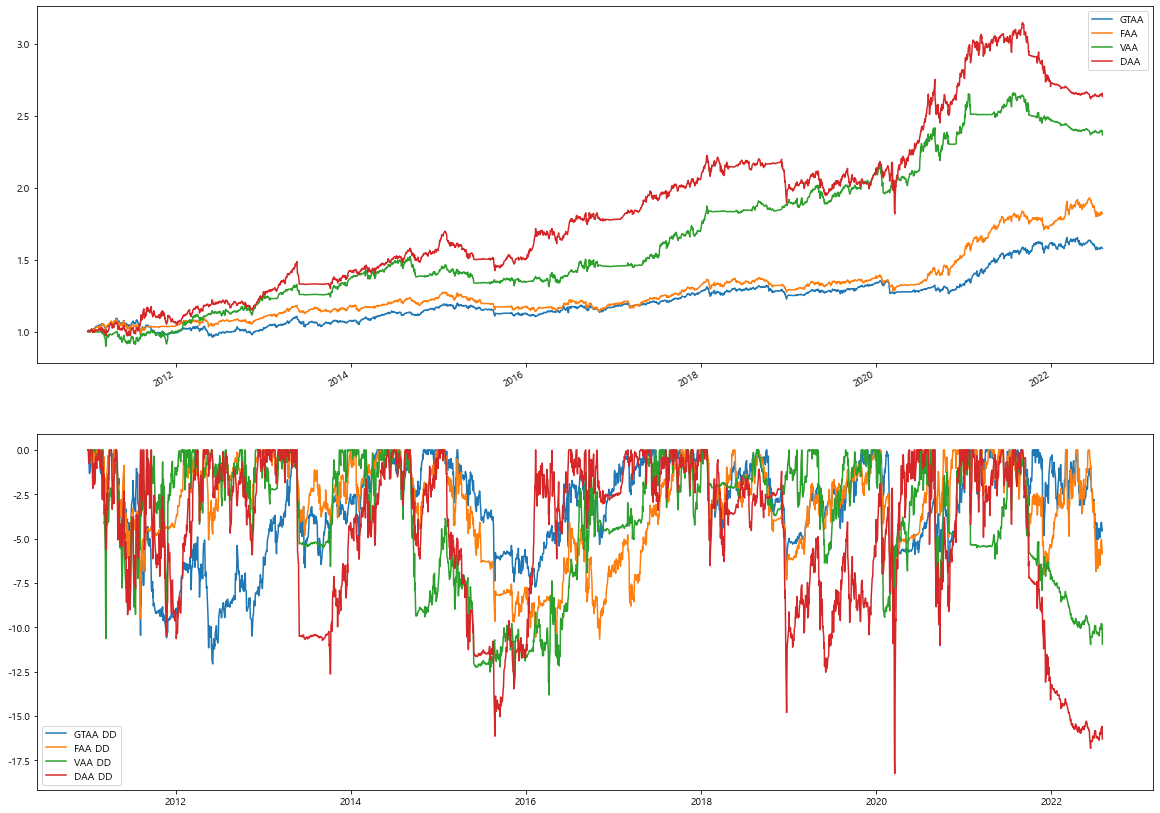

In [11]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,16))

# 수익곡선
plt.subplot(2,1,1)
gtaaCumReturn.plot(label="GTAA")
faaCumReturn.plot(label="FAA")
vaaCumReturn.plot(label="VAA")
daaCumReturn.plot(label="DAA")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(-gtaaDD, label="GTAA DD")
plt.plot(-faaDD, label="FAA DD")
plt.plot(-vaaDD, label="VAA DD")
plt.plot(-daaDD, label="DAA DD")
plt.legend()

plt.show()

#### 결론

* 전략이 복잡하다고 해서 좋은 결과를 보장한다는 법이 없다.
* 항상 이익만 보는 전략이란 없다.
* 전략도 하나의 종목으로 간주하고 두개 ~ 세개 전략을 실행하자.
* 결국 중요한 것은 어떤 전략이든, 자신이 꾸준히 실행할 수 있는 전략을 선택하여 장기간 투자한다면 이익을 얻을 수 있다.